In [1]:
import tensorflow as tf

In [2]:
# Load various imports 
from datetime import datetime
from os import listdir
from os.path import isfile, join

import librosa
import librosa.display

import numpy as np
import pandas as pd



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical 
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
mypath = "/home/vadim/ctci-python/edx/cf/more_yandex/train"
filenames = [f for f in listdir(mypath) if (isfile(join(mypath, f)) and f.endswith('.wav'))] 

In [4]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(name[:-4])

p_id_in_file = np.array(p_id_in_file) 

In [5]:
print(p_id_in_file)

['535df6bcbb6ddee2e21364b643fb7435' 'a8e2e7636226cb39ddac2b98d2a62606'
 '5dbbdcd354885a46f57d6330c68b63fe' ... '3a423fae5c860fe0348993fa4a14049d'
 '9fed420c4dded6e1ea8f264e730eff32' '83594e3ec9e164cbe5af64213f41fcbf']


In [14]:
max_pad_len = 280 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=6) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [15]:
filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [16]:
df = pd.read_csv("/home/vadim/ctci-python/edx/cf/more_yandex/train/targets.tsv",sep='\t', header=None) # patient diagnosis file

In [17]:
df.head()

,0,1
0,5d1f7e43366513a1d0a6ec5640c3dc24,1
1,9a701a4536a05b6610a590a9fe702ed8,1
2,cad0b8547008d1524c1a0e5fd51f9908,1
3,4bbe607e7dc95460e2cc1a6ee5f4dfa6,0
4,30fb32cba90b34af26f3f14f5d636805,0


In [18]:
labels = df[1].astype('int')

In [19]:
labels

0        1
1        1
2        1
3        0
4        0
        ..
13931    1
13932    0
13933    1
13934    0
13935    0
Name: 1, Length: 13936, dtype: int64

In [20]:
features = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

Finished feature extraction from  13936  files


In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[8], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [22]:
features = np.array(features) # convert to numpy array

In [23]:
# print class counts
unique_elements, counts_elements = np.unique(labels, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1]
 [7620 6316]]


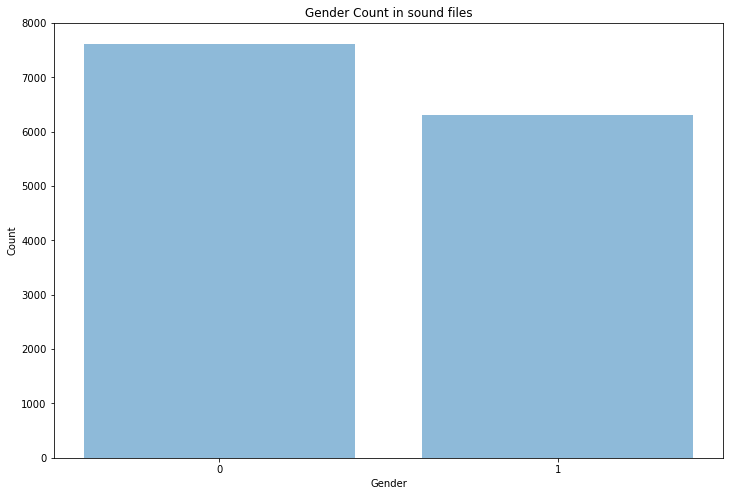

In [24]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('Gender Count in sound files')
plt.show()



In [25]:
# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels)
oh_labels = to_categorical(i_labels) 

In [26]:
# add channel dimension for CNN
features = np.reshape(features, (*features.shape,1)) 

In [27]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(features, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

In [28]:
x_train.shape[1]

40

In [29]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from keras.layers import Input, Dense, Add
from keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(40, 280, 1))
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [2, 5, 5, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample = (j == 0 and i != 0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(2, activation='sigmoid')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [30]:
model = create_res_net()

In [ ]:
#-----------------------------------------------------------------------------------------------------------------

In [ ]:
from tensorflow.keras.layers import Flatten, Dense, Input, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, img_to_array
import tensorflow as tf

import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt 

In [ ]:
resnet_model = ResNet50V2(include_top=False, weights='imagenet',input_shape=(224,224,3))
#base_model.trainable = False



In [ ]:
for layer in resnet_model.layers:
    layer.trainable = False

In [ ]:
resnet_model.trainable = False


In [ ]:
resnet_model.summary()

In [ ]:
x = Conv2D(128, (3, 3), activation='relu')(resnet_model.output)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(100,activation='relu')(x)
x = Dense(2,activation='softmax')(x)

model = Model(inputs=resnet_model.input, outputs=x)

In [ ]:
model.summary()

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
hist = model.fit(x_train,
                validation_data = x_test,
                epochs = 20,
                steps_per_epoch=len(x_train),
                validation_steps=len(x_test))

In [ ]:
num_rows = 40
num_columns = 224
num_channels = 3

num_labels = oh_labels.shape[1]
model = base_model

In [ ]:
num_rows = 40
num_columns = 224
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [ ]:
#-------------------------------------------------------------------------------------------------------

In [31]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 280, 1)] 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 40, 280, 1)   4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 280, 64)  640         batch_normalization[0][0]        
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 40, 280, 64)  0           conv2d[0][0]                     
______________________________________________________________________________________________

88/88 [==============================] - 5s 56ms/step - loss: 0.7086 - accuracy: 0.5118
Pre-training accuracy: 51.1836%


In [ ]:
# train model
num_epochs = 300
num_batch_size = 128

callbacks = [
    ModelCheckpoint(
        filepath='mymodel2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/300
88/88 [==============================] - ETA: 0s - loss: 0.7239 - accuracy: 0.5214
Epoch 00001: val_accuracy improved from -inf to 0.54663, saving model to mymodel2_01.h5
88/88 [==============================] - 66s 746ms/step - loss: 0.7239 - accuracy: 0.5214 - val_loss: 0.7201 - val_accuracy: 0.5466
Epoch 2/300
88/88 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5300
Epoch 00002: val_accuracy did not improve from 0.54663
88/88 [==============================] - 63s 719ms/step - loss: 0.6932 - accuracy: 0.5300 - val_loss: 0.7250 - val_accuracy: 0.4706
Epoch 3/300
88/88 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5342
Epoch 00003: val_accuracy did not improve from 0.54663
88/88 [==============================] - 62s 706ms/step - loss: 0.6931 - accuracy: 0.5342 - val_loss: 0.7718 - val_accuracy: 0.4609
Epoch 4/300
88/88 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5275
Epoch 00004: val_accuracy 

In [ ]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])



In [ ]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes = 2 # number of classes

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [ ]:
c_names = ['male', 'female']

In [ ]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()


In [ ]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))